<a href="https://colab.research.google.com/github/TTTanya/House_Prices_Kaggle/blob/main/PredictHousePricesKaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting house prices** 

In [ ]:
!pip install pycomp

In [ ]:
!pip install impyute

In [ ]:
from pycomp.viz.insights import *

In [6]:
import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
from pycomp.ml.transformers import FiltraColunas
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax, boxcox
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDRegressor, RidgeCV, LassoCV, BayesianRidge
from sklearn.cluster import DBSCAN
from impyute.imputation.cs import fast_knn
import math
import io
%matplotlib inline

In [7]:
train = files.upload()

Saving train_houses.csv to train_houses.csv


In [51]:
df = pd.read_csv(io.BytesIO(train['train_houses.csv']))

In [ ]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
test = files.upload()

Saving test_houses.csv to test_houses.csv


In [52]:
df_test = pd.read_csv(io.BytesIO(test['test_houses.csv']))

Correlation of features with SalePrice

In [ ]:
corr_var = df.corr()
corr_var[['SalePrice']].sort_values(by='SalePrice', ascending = False).head(10)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


In [ ]:
corr_var[['SalePrice']].sort_values(by='SalePrice', ascending = False).tail(5)

,SalePrice
YrSold,-0.028923
OverallCond,-0.077856
MSSubClass,-0.084284
EnclosedPorch,-0.128578
KitchenAbvGr,-0.135907


In [53]:
df_num = df.select_dtypes(exclude='object')
df_cat = df.select_dtypes(include='object')

In [54]:
df_test_num = df_test.select_dtypes(exclude='object')
df_test_cat = df_test.select_dtypes(include='object')

In [ ]:
df_num.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000


In [ ]:
df_cat.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


Plot distribution of numerical continious features



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
/usr/local/lib/python3.6/dist-packages/seaborn/distribu

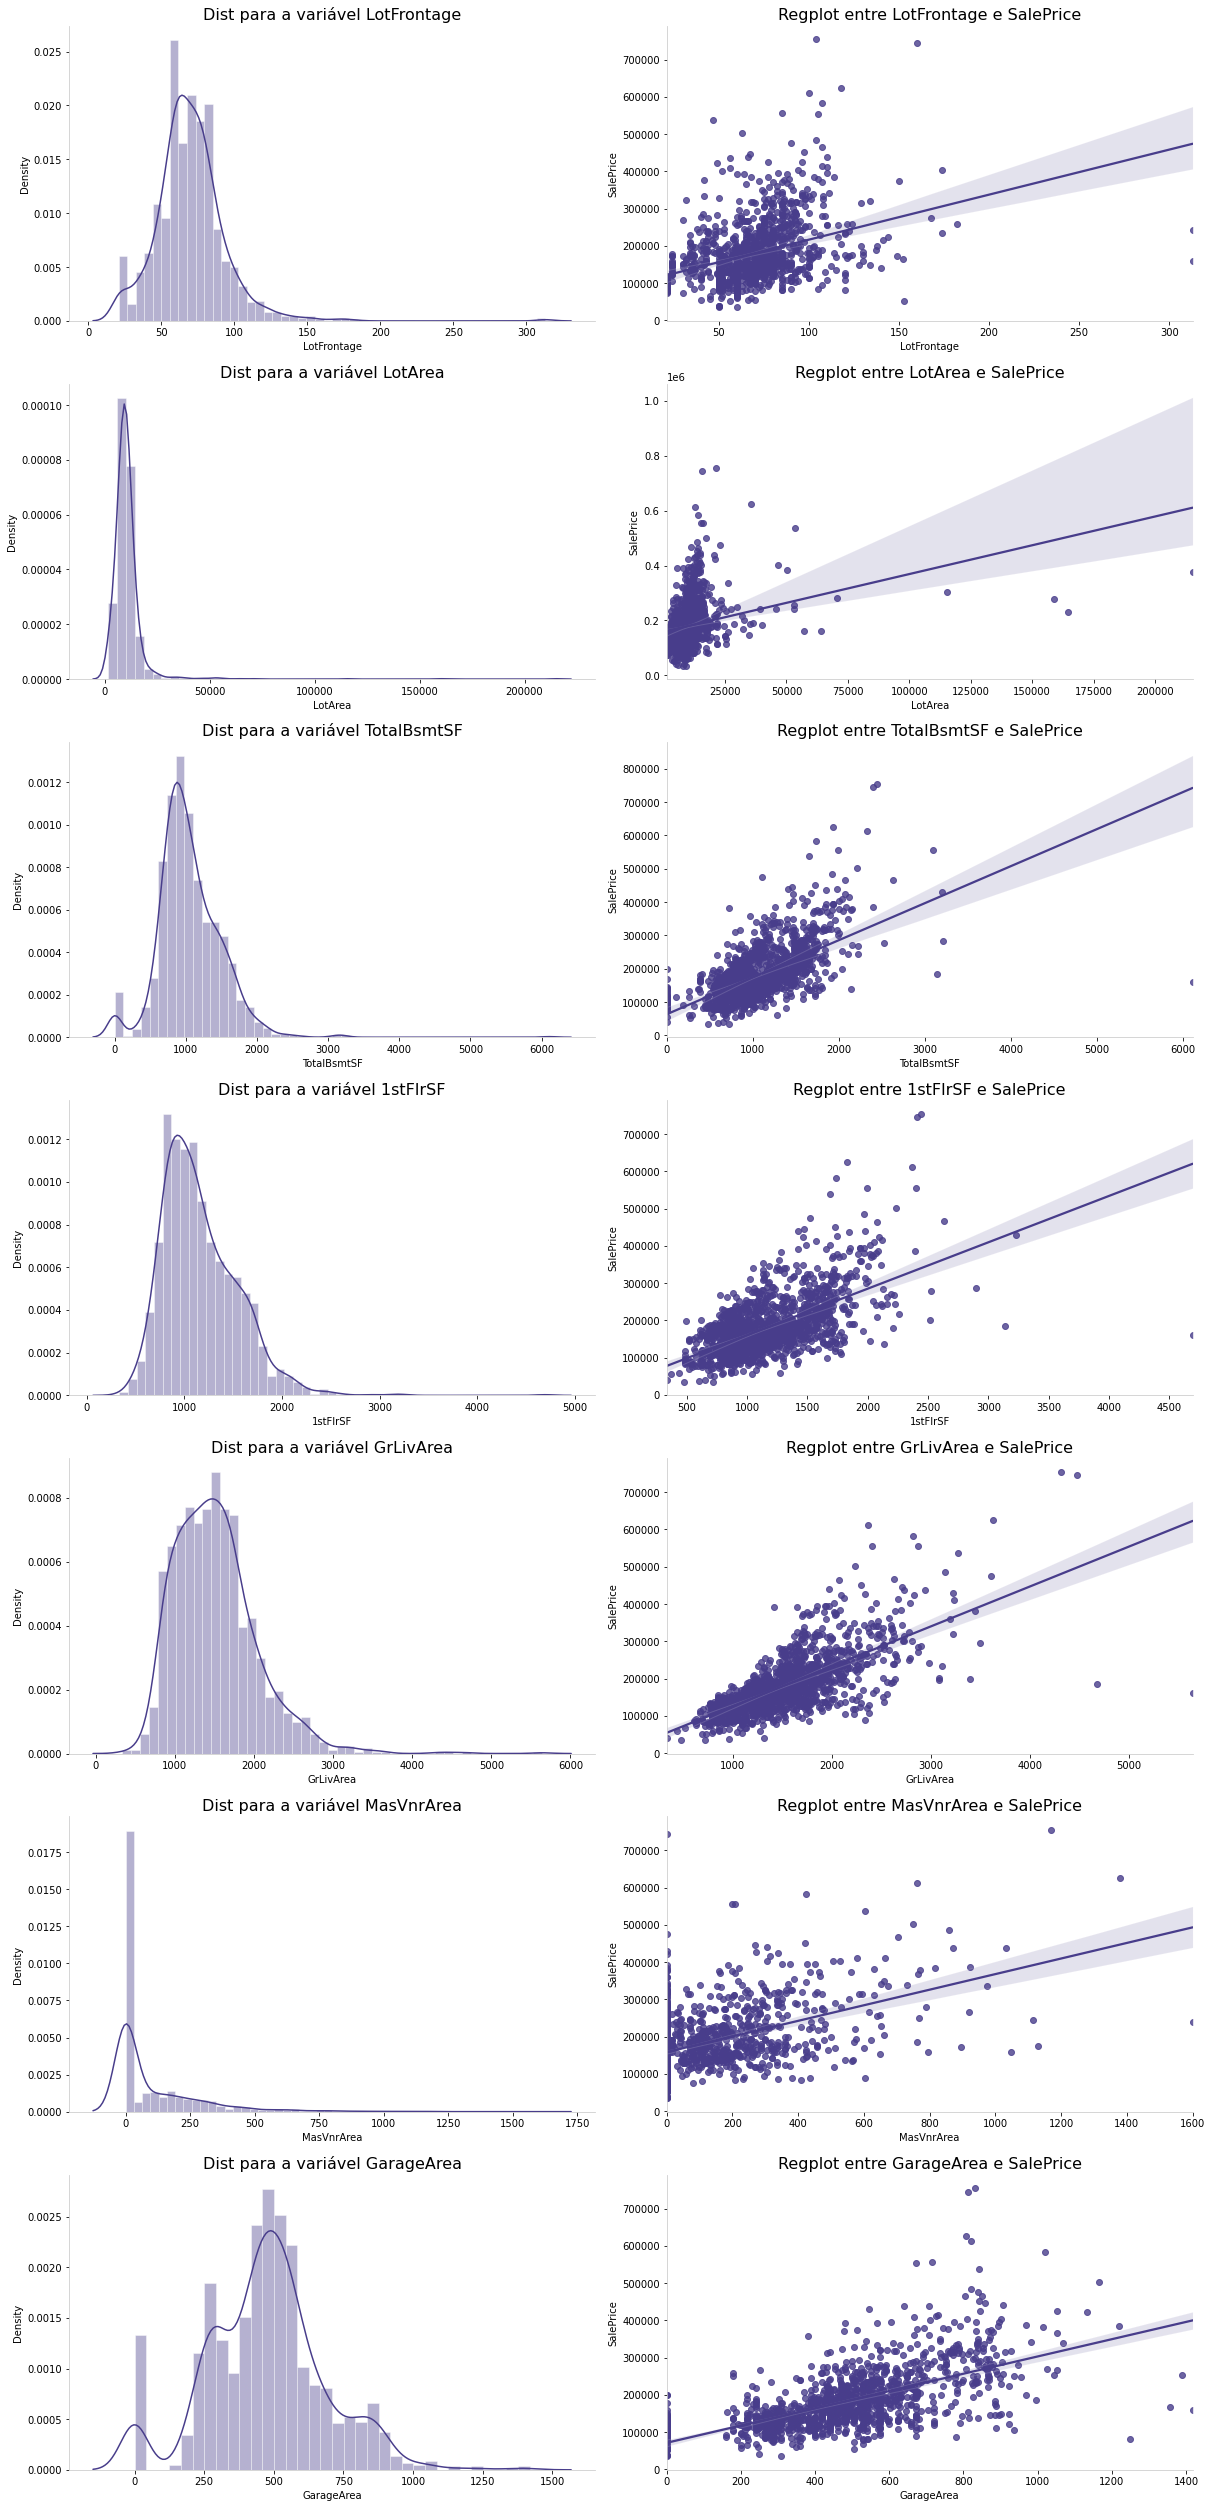

In [ ]:
df_num_cont = ['LotFrontage', 'LotArea', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'MasVnrArea', 'GarageArea']
plot_multiple_dist_scatterplot(df=df, col_list=df_num_cont, y_col='SalePrice')

Plot ratio between categories in categorical features

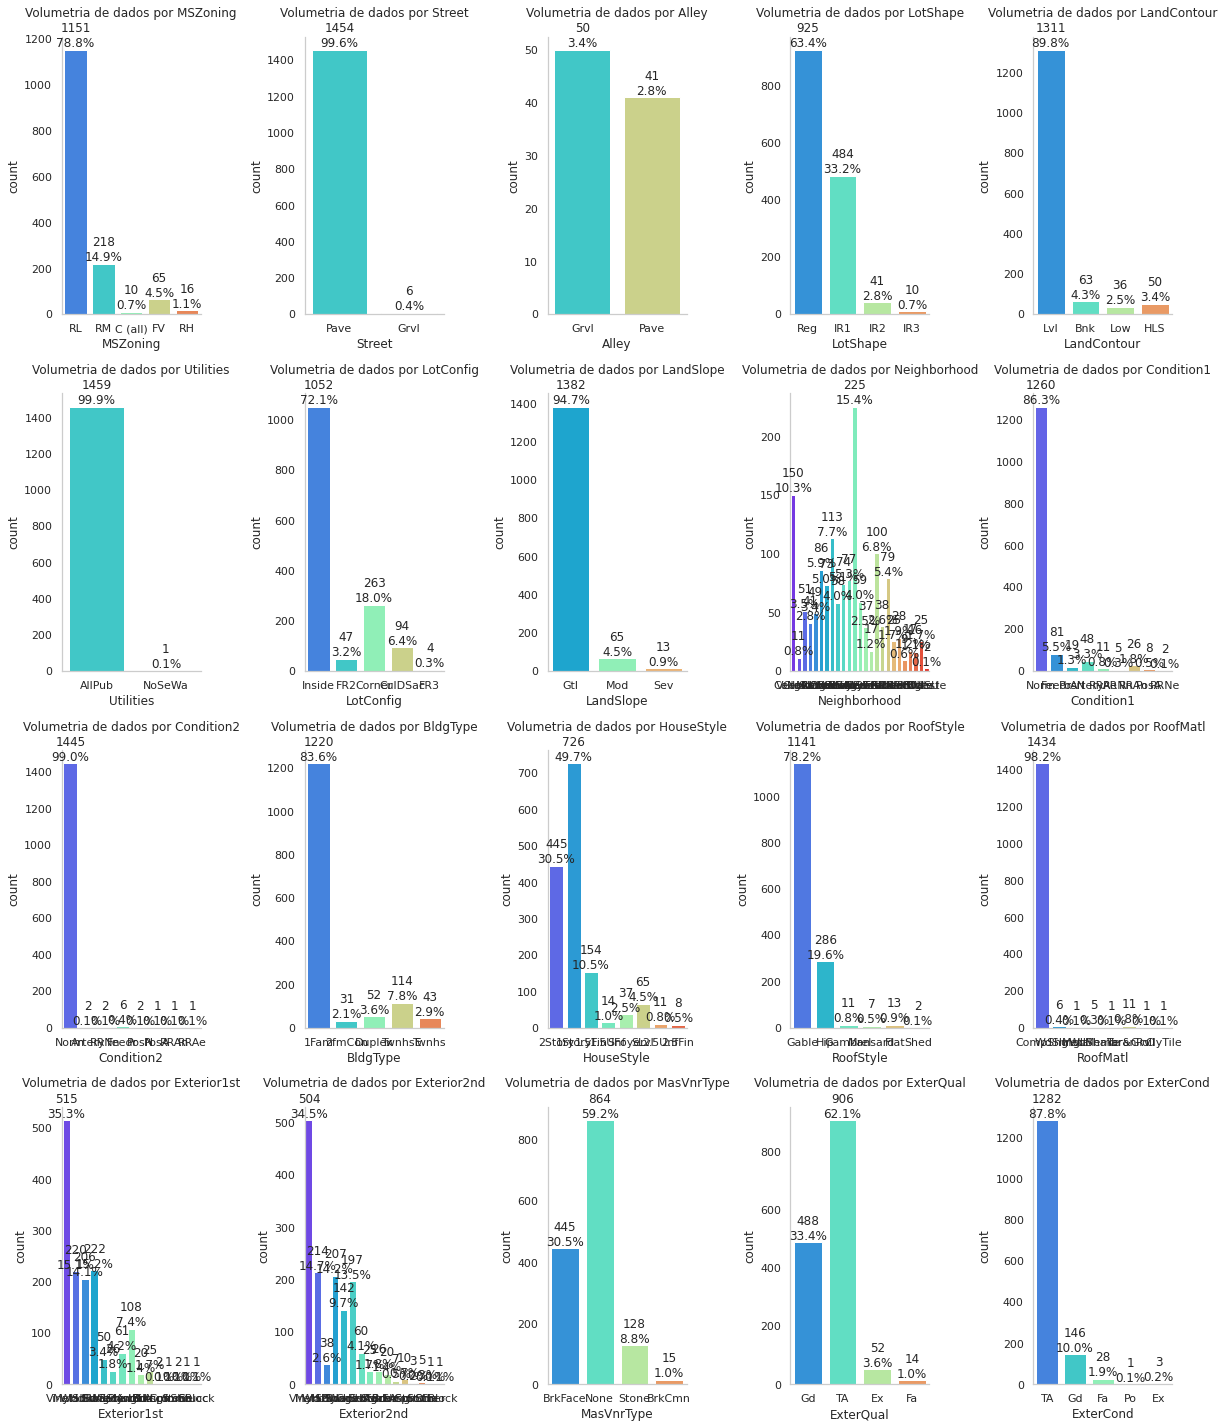

In [ ]:
plot_multiple_countplots(df=df_cat,n_cols=5, col_list=df_cat.iloc[:, :20].columns)

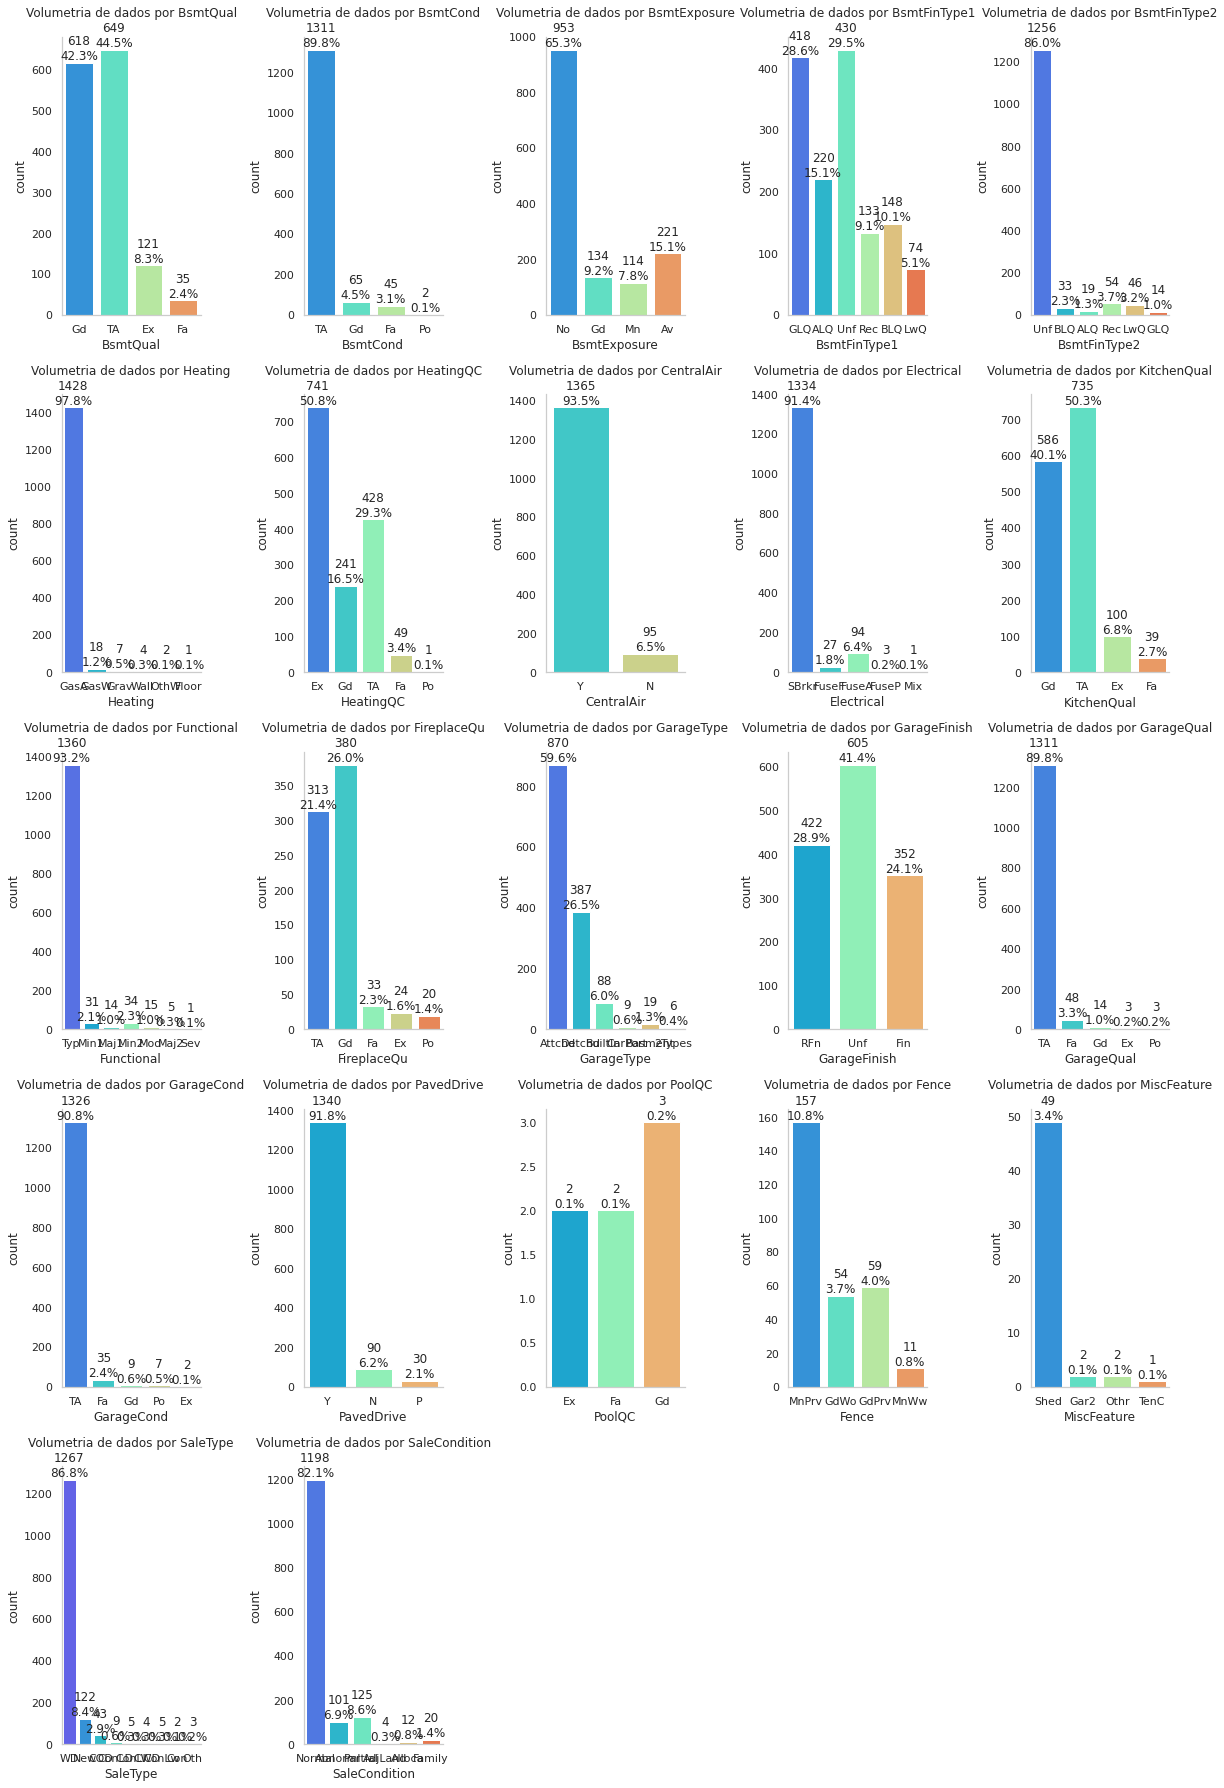

In [ ]:
plot_multiple_countplots(df=df_cat,n_cols=5, col_list=df_cat.iloc[:, 21:].columns)

Plot ratio of SalePrice depending on the sold month

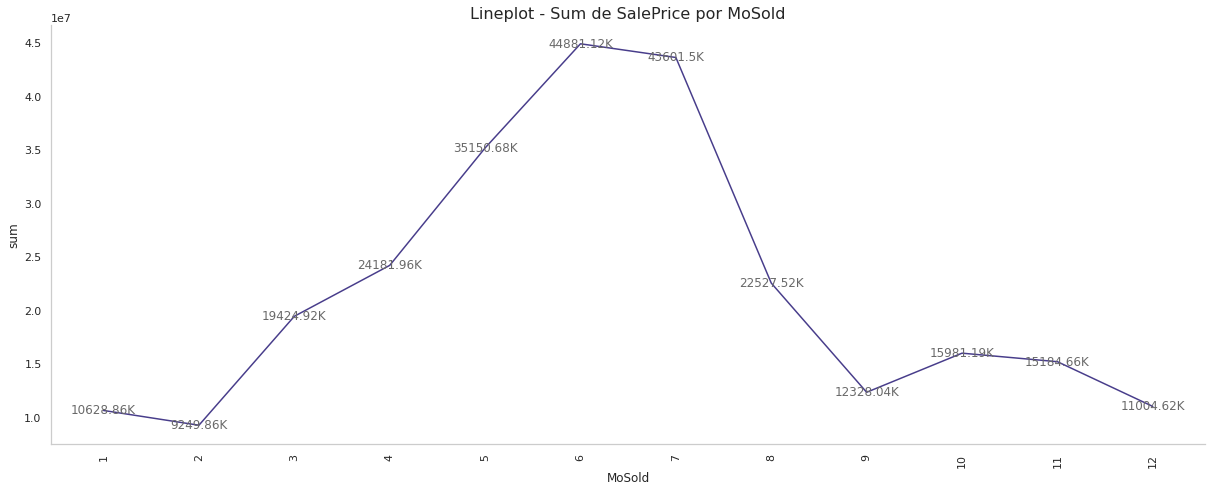

In [ ]:
plot_evolutionplot(df=df, x='MoSold', y='SalePrice', agg_type='sum', date_col = False)

Percentage of NaN values in features

In [ ]:
df_overview = data_overview(df=df, corr=True, target='SalePrice')
df_overview.sort_values(by='pct_null', ascending=False).head(10)

,feature,qtd_null,pct_null,dtype,qtd_cat,target_pearson_corr
0,PoolQC,1453,0.995205,object,3,NaN
1,MiscFeature,1406,0.963014,object,4,NaN
2,Alley,1369,0.937671,object,2,NaN
3,Fence,1179,0.807534,object,4,NaN
4,FireplaceQu,690,0.472603,object,5,NaN
5,LotFrontage,259,0.177397,float64,0,0.351799
6,GarageYrBlt,81,0.055479,float64,0,0.486362
7,GarageCond,81,0.055479,object,5,NaN
9,GarageFinish,81,0.055479,object,3,NaN
10,GarageQual,81,0.055479,object,5,NaN


In [ ]:
df_test_overview = data_overview(df=df_test)
df_test_overview.sort_values(by='pct_null', ascending=False).head(10)

,feature,qtd_null,pct_null,dtype,qtd_cat
0,PoolQC,1456,0.997944,object,2
1,MiscFeature,1408,0.965045,object,3
2,Alley,1352,0.926662,object,2
3,Fence,1169,0.801234,object,4
4,FireplaceQu,730,0.500343,object,5
5,LotFrontage,227,0.155586,float64,0
6,GarageYrBlt,78,0.053461,float64,0
7,GarageQual,78,0.053461,object,4
8,GarageFinish,78,0.053461,object,3
9,GarageCond,78,0.053461,object,5


In [ ]:
df_cat.columns[df_cat.isnull().any()]

Index(['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature'],
      dtype='object')

In [ ]:
df_test_cat.columns[df_test_cat.isnull().any()]

Index(['MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType'],
      dtype='object')

Plot distribution of numrical NaN features to decide which type of imputer to use

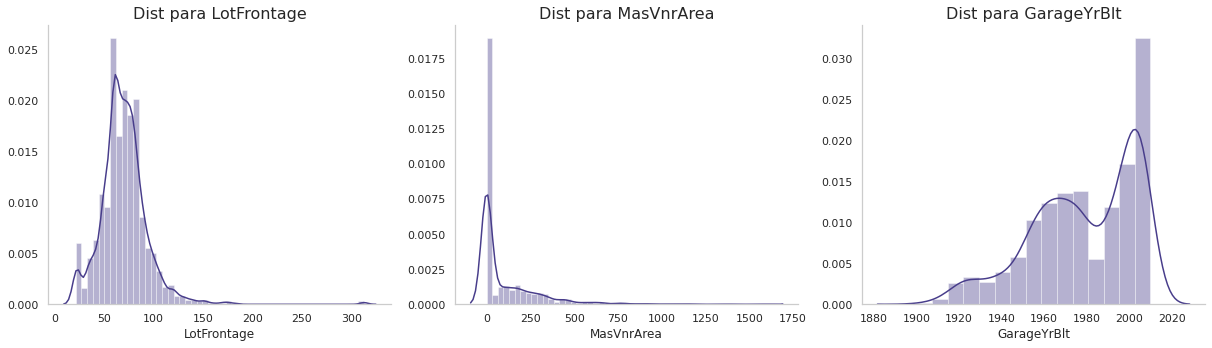

In [55]:
df_null_cols = df_num.columns[df_num.isnull().any()]
plot_multiple_distplots(df=df, col_list=df_null_cols)

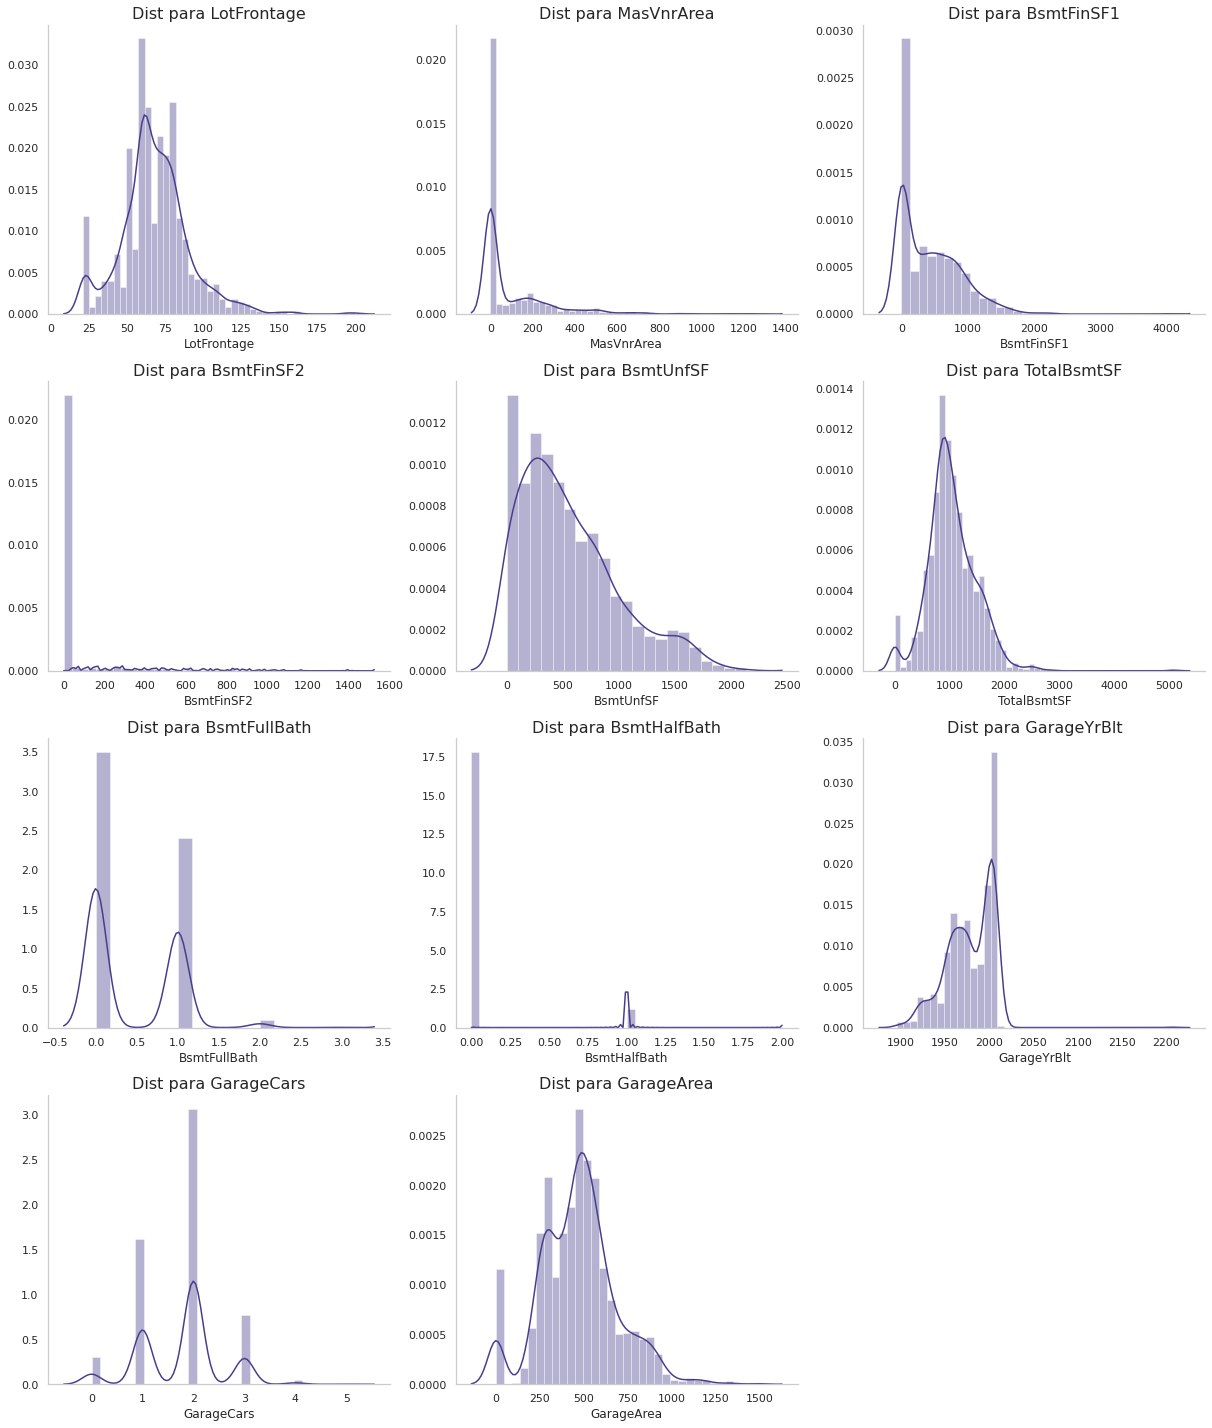

In [56]:
df_test_null_cols = df_test_num.columns[df_test_num.isnull().any()]
plot_multiple_distplots(df=df_test, col_list= df_test_null_cols)

In [57]:
num_feat = df.dtypes[df.dtypes != 'object'].index
num_test_feat = df_test.dtypes[df_test.dtypes != 'object'].index

Impute NaN numerical values with kNN depending on 30 neighbours

In [58]:
impute_knn = fast_knn(df[num_feat][df_null_cols].values, k=30)
impute_test_knn = fast_knn(df_test[num_test_feat][df_test_null_cols].values, k=30)

In [59]:
df_imp = pd.DataFrame(impute_knn)
df_test_imp = pd.DataFrame(impute_test_knn)

In [60]:
df[df_null_cols] = df_imp
df_test[df_test_null_cols] = df_test_imp

Impute NaN categorical features with 'NotAvailable'

In [63]:
for i in df_cat.columns[df_cat.isnull().any()]:
    df[i].fillna('NotAvailable', inplace=True)

In [64]:
for i in df_test_cat.columns[df_test_cat.isnull().any()]:
    df_test[i].fillna('NotAvailable', inplace=True)

Feature engeneering

In [65]:
df['TotalBaths'] = df['FullBath'] + df['HalfBath'] + df['BsmtFullBath'] + df['BsmtHalfBath']
df['TotalFloors'] = df['1stFlrSF'] + df['2ndFlrSF']
df['TotalPorch'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF']
df['OverAllCondQual'] = (df['OverallCond'] + df['OverallQual'])/2
df['YearBetweenRemod'] = df['YearRemodAdd'] - df['YearBuilt']
df['YearsBS'] = df['YrSold'] - df['YearBuilt']

In [66]:
df_test['TotalBaths'] = df_test['FullBath'] + df_test['HalfBath'] + df_test['BsmtFullBath'] + df_test['BsmtHalfBath']
df_test['TotalFloors'] = df_test['1stFlrSF'] + df_test['2ndFlrSF']
df_test['TotalPorch'] = df_test['OpenPorchSF'] + df_test['3SsnPorch'] + df_test['EnclosedPorch'] + df_test['ScreenPorch'] + df_test['WoodDeckSF']
df_test['OverAllCondQual'] = (df_test['OverallCond'] + df_test['OverallQual'])/2
df_test['YearBetweenRemod'] = df_test['YearRemodAdd'] - df_test['YearBuilt']
df_test['YearsBS'] = df_test['YrSold'] - df_test['YearBuilt']

Drop features that are practically constant

In [67]:
df = df.drop(['Condition2', 'RoofMatl', 'Heating', 'Functional'], axis=1)
df_test = df_test.drop(['Condition2', 'RoofMatl', 'Heating', 'Functional'], axis=1)

In [68]:
corr_var = df.corr()
corr_var[['SalePrice']].sort_values(by='SalePrice', ascending = False).head(10)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
TotalFloors,0.716883
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
TotalBaths,0.613005
1stFlrSF,0.605852
OverAllCondQual,0.594786


In [ ]:
#var_thresholder = VarianceThreshold()
#df_num = var_thresholder.fit_transform(df_num)

In [ ]:
#for i in df_num.columns:
#  var_thresholder.fit_transform(df[[i]])
#for i in df_test_num.columns:
#  var_thresholder.transform(df_test[[i]])

In [45]:
num_feat = df.dtypes[df.dtypes != "object"].index

Look at the high skeewed features

In [ ]:
df_skew = pd.DataFrame(data={'skewness':skew(df[num_feat]), 'feature':df[num_feat].columns}).sort_values(by='skewness', ascending=False)

In [ ]:
df_skew.head(10)

,skewness,feature
31,24.451640,MiscVal
30,14.813135,PoolArea
2,12.195142,LotArea
28,10.293752,3SsnPorch
13,9.002080,LowQualFinSF
20,4.483784,KitchenAbvGr
8,4.250888,BsmtFinSF2
29,4.117977,ScreenPorch
16,4.099186,BsmtHalfBath
27,3.086696,EnclosedPorch


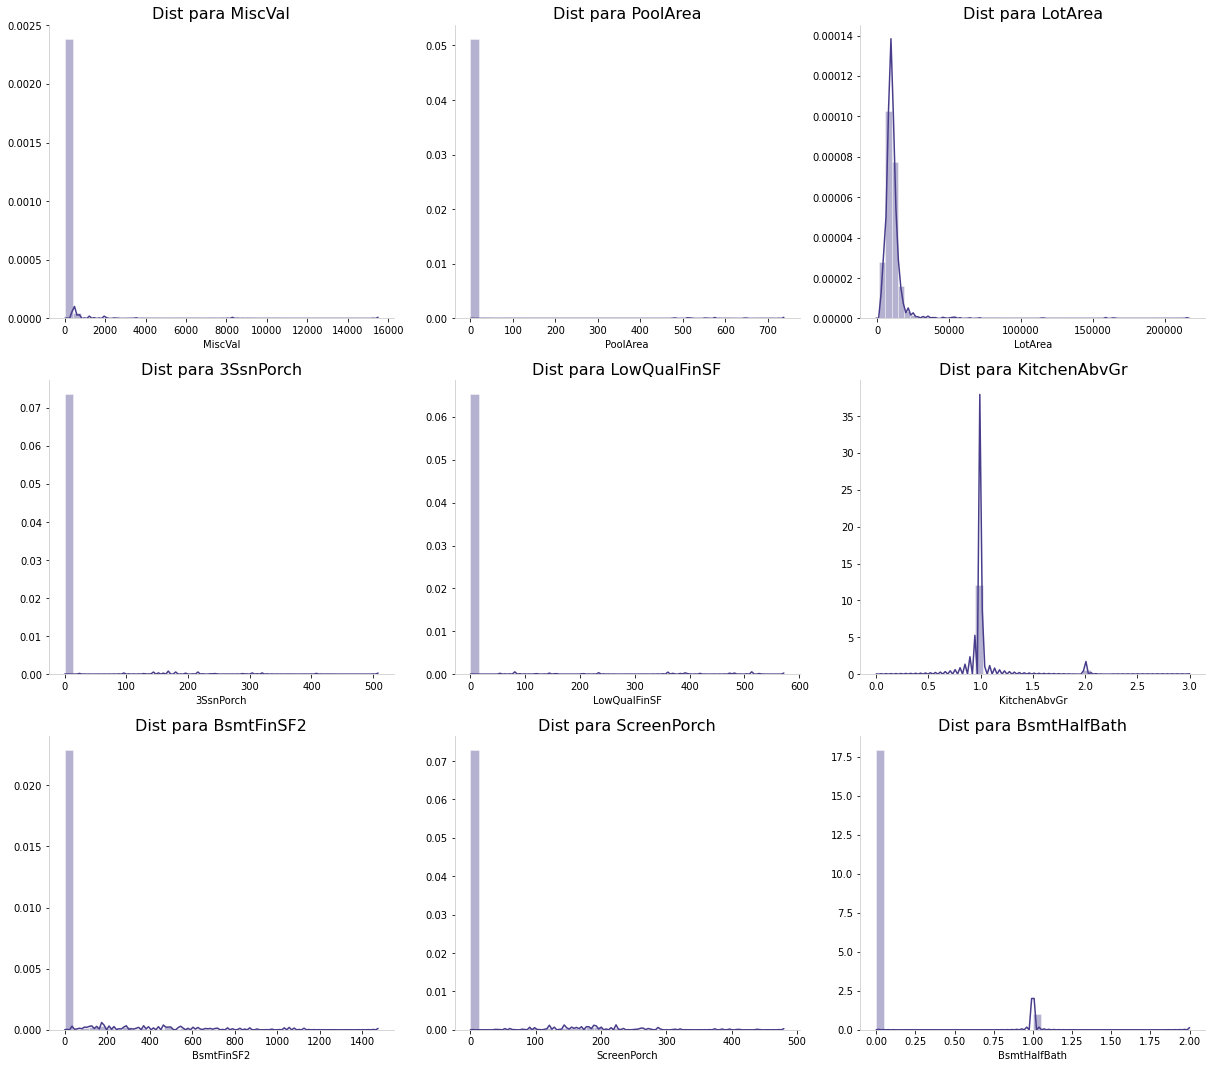

In [ ]:
plot_multiple_distplots(df=df, col_list=['MiscVal', 'PoolArea', 'LotArea', '3SsnPorch', 'LowQualFinSF', 'KitchenAbvGr', 'BsmtFinSF2', 'ScreenPorch', 'BsmtHalfBath'])

In [ ]:
high_skewed_feat = df_skew.query("feature in ['MiscVal', 'PoolArea', '3SsnPorch', 'LowQualFinSF', 'KitchenAbvGr', 'BsmtFinSF2', 'ScreenPorch', 'BsmtHalfBath']")

In [ ]:
#for i in high_skewed_feat['feature']:
#   df[i] = boxcox1p(df[i], boxcox_normmax(df[i] + 1))

In [ ]:
#for i in high_skewed_feat['feature']:
#   df_test[i] = boxcox1p(df_test[i], boxcox_normmax(df_test[i] + 1))

Apply log transformation for LotArea

In [69]:
df['LotArea'] = np.log1p(df.LotArea)
df_test['LotArea'] = np.log1p(df_test.LotArea)

In [70]:
num_feat = df.dtypes[df.dtypes != 'object'].index

In [71]:
num_feat = num_feat.drop(['Id'])

In [72]:
scaler =  StandardScaler()
X_scaled = scaler.fit_transform(df[num_feat])

Search for anomalies using DBSCAN

In [73]:
out_perc = 1.
num_clust = []
anomaly_perc = []
eps = 0.05
eps_itteration = [eps]

while out_perc > 0.1:
  model = DBSCAN(eps=eps).fit(X = X_scaled)
  labels = model.labels_
  num_clust.append(len(np.unique(labels))-1)
  labels = np.array([1 if label == -1 else 0 for label in labels])
  out_perc = sum(labels==1)/len(labels)
  eps += 0.05
  eps_itteration.append(eps)
  anomaly_perc.append(out_perc)

model = DBSCAN(eps=eps)
model.fit(X = X_scaled)
density_out = np.array([1 if label == -1 else 0 for label in model.labels_])

In [74]:
print('Number of anomalies: {}\nPercentage of anomalies: {:.2f}%'.format(sum(density_out), sum(density_out)*100/len(density_out)))

Number of anomalies: 129
Percentage of anomalies: 8.84%


In [75]:
labeled_df = df.copy()
labeled_df['IsAnomaly'] = density_out

Make new dataframe without anomalies

In [76]:
new_df = labeled_df[labeled_df['IsAnomaly'] == 0]
df = new_df.copy()
df = df.drop(['IsAnomaly'], axis = 1)

In [77]:
df['label'] = 1
df_test['label'] = 0

concat_df = pd.concat([df , df_test])
columns_cat = concat_df.select_dtypes(include='object').columns

Concatenate train and test datasets to get the same features

In [78]:
features_df = pd.get_dummies(concat_df, columns=columns_cat, dummy_na=True, drop_first=True)
df = features_df[features_df['label'] == 1]
df_test = features_df[features_df['label'] == 0]

df = df.drop('label', axis=1)
df_test = df_test.drop('label', axis=1)

In [ ]:
'''cat_num = {'Utilities': {'AllPub': 3, 'NoSewr': 2, 'NoSeWa': 1, 'ELO': 0},
           'ExterQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}, 
           'ExterCond': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
           'BsmtQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0, 'NotAvailable': -1},
           'BsmtCond': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0, 'NotAvailable': -1},
           'BsmtExposure': {'Gd': 3, 'Av': 2, 'Mn': 1, 'No': 0, 'NotAvailable': -1},
           'BsmtFinType1': {'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec': 2, 'LwQ': 1, 'Unf': 0, 'NotAvailable': -1},
           'BsmtFinType2': {'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec': 2, 'LwQ': 1, 'Unf': 0, 'NotAvailable': -1},
           'HeatingQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
           'KitchenQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0, 'NotAvailable': -1},
           'FireplaceQu': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0, 'NotAvailable': -1},
           'GarageQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0, 'NotAvailable': -1},
           'GarageCond': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0, 'NotAvailable': -1},
           'PoolQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'NotAvailable': -1},
           'Fence': {'GdPrv': 3, 'MnPrv': 2, 'GdWo': 1, 'MnWw': 0, 'NotAvailable': -1}}'''

In [79]:
df['IsGarage'] = np.array([0 if label == 1 else 1 for label in df['GarageQual_NotAvailable']])
df['IsPool'] = np.array([0 if label == 1 else 1 for label in df['PoolQC_NotAvailable']])
df['IsFireplace'] = np.array([0 if label == 1 else 1 for label in df['FireplaceQu_NotAvailable']])
df['IsFence'] = np.array([0 if label == 1 else 1 for label in df['Fence_NotAvailable']])

In [80]:
df_test['IsGarage'] = np.array([0 if label == 1 else 1 for label in df_test['GarageQual_NotAvailable']])
df_test['IsPool'] = np.array([0 if label == 1 else 1 for label in df_test['PoolQC_NotAvailable']])
df_test['IsFireplace'] = np.array([0 if label == 1 else 1 for label in df_test['FireplaceQu_NotAvailable']])
df_test['IsFence'] = np.array([0 if label == 1 else 1 for label in df_test['Fence_NotAvailable']])

Apply log transformation for SalePrice 

In [82]:
df['SalePrice_Log'] = np.log1p(df.SalePrice)

In [ ]:
#corr_var = df.corr()
#cols = corr_var[corr_var['SalePrice'] >abs(0.05)].index

In [83]:
X_train = df.drop(['SalePrice', 'Id', 'SalePrice_Log'], axis = 1)
y_train = df['SalePrice_Log']

In [84]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,TotalBaths,TotalFloors,TotalPorch,OverAllCondQual,...,GarageCond_Gd,GarageCond_NotAvailable,GarageCond_Po,GarageCond_TA,GarageCond_nan,PavedDrive_P,PavedDrive_Y,PavedDrive_nan,PoolQC_Gd,PoolQC_NotAvailable,PoolQC_nan,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NotAvailable,Fence_nan,MiscFeature_NotAvailable,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_nan,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_NotAvailable,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan,IsGarage,IsPool,IsFireplace,IsFence
0,60,65.0,9.042040,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2,2008,4.0,1710,61,6.0,...,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
1,20,80.0,9.169623,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,5,2007,3.0,1262,298,7.0,...,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0
2,60,68.0,9.328212,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0,9,2008,4.0,1786,42,6.0,...,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0
3,70,60.0,9.164401,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0,2,2006,2.0,1717,307,6.0,...,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
4,60,84.0,9.565284,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,12,2008,4.0,2198,276,6.5,...,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0


In [85]:
scaler1 = StandardScaler()
X_train_scaled = scaler1.fit_transform(X_train)

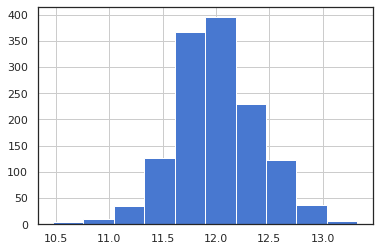

In [62]:
y_train.hist()

In [41]:
kfold = KFold(shuffle=True, random_state=42)

In [42]:
def cross_score(clf, X_train, y_train, kfold):
  return cross_val_score(estimator = clf, X = X_train, y = y_train, cv = kfold, scoring='neg_mean_squared_log_error').mean()

Test stacking regressor with RidgeCV, BayesianRidge, GradientBoostingRegressor, RandomForest (most qualitative algorithms for our data)

In [95]:
def stacking(X_train, y_train):
  estimators = [('gb', GradientBoostingRegressor(n_estimators=350, random_state=42)), ('rf', RandomForestRegressor(random_state=42, n_estimators=400)), ('r', RidgeCV())]
  clf_stack = StackingRegressor(estimators=estimators, final_estimator = BayesianRidge(alpha_1= 0.001, alpha_2= 1e-06, lambda_1= 1e-06, lambda_2= 0.001))
  clf_stack.fit(X_train, y_train)
  return cross_score(clf_stack, X_train, y_train, kfold)

In [96]:
score = stacking(X_train, y_train)
print('Best cross-validation score: ', score)

Best cross-validation score:  -7.472397480211962e-05


In [67]:
score = stacking(X_train_scaled, y_train)
print('Best cross-validation score: ', score)

Best cross-validation score:  -7.811770171970136e-05


Test random forest regressor with different 'n_estimators'

In [98]:
def random_forest(X_train, y_train):
  clf_RF = RandomForestRegressor(random_state=42, n_jobs=-1)
  params = {'n_estimators': [350, 400] }
  grid_RF = GridSearchCV(clf_RF, params, cv=5, return_train_score=True)
  grid_RF.fit(X_train, y_train)
  grid_best_RF = grid_RF.best_estimator_
  grid_best_RF.fit(X_train, y_train)
  feature_imp = grid_best_RF.feature_importances_
  feature_imp_df = pd.DataFrame({'features': list(X_train), 'feature_imp': feature_imp})
  feature_imp_df = feature_imp_df.sort_values('feature_imp', ascending=False)
  return cross_score(grid_best_RF, X_train, y_train, kfold), grid_RF.best_params_, feature_imp_df

In [89]:
score, parameters, importance = random_forest(X_train, y_train)
print('Best cross-validation score: ', score, '\nBest parameters: ', parameters, '\nImportant features: ', importance)

Best cross-validation score:  -0.00010361242650449014 
Best parameters:  {'n_estimators': 350} 
Important features:             features  feature_imp
3       OverallQual     0.554815
36       TotalBaths     0.066001
11      TotalBsmtSF     0.042605
37      TotalFloors     0.039564
15        GrLivArea     0.039049
..              ...          ...
209   HeatingQC_nan     0.000000
47     MSZoning_nan     0.000000
251  GarageCond_nan     0.000000
164   ExterQual_nan     0.000000
68    LotConfig_nan     0.000000

[287 rows x 2 columns]


In [ ]:
score, parameters, importance = random_forest(X_train_scaled, y_train)
print('Best cross-validation score: ', score, '\nBest parameters: ', parameters, '\nImportant features: ', importance)

Test ridge regression with different 'alphas'

In [100]:
def ridge(X_train, y_train):
  clf_ridge = RidgeCV(alphas=[1e-6, 1e-3, 1e-1, 1], cv=5, scoring='neg_mean_squared_log_error').fit(X_train, y_train)
  return cross_score(clf_ridge, X_train, y_train, kfold)

In [101]:
score = ridge(X_train, y_train)
print('Best cross-validation score: ', score)

Best cross-validation score:  -8.137982188250177e-05


In [102]:
score = ridge(X_train_scaled, y_train)
print('Best cross-validation score with scaled X: ', score)

Best cross-validation score with scaled X:  -8.982426234578392e-05


Test bayesian regression with different 'alphas' and 'lambdas' 

In [ ]:
def bayesian(X_train, y_train):
  clf_BR = BayesianRidge().fit(X_train, y_train)
  params = {'alpha_1': [1e-3, 1e-6, 1e-5], 'alpha_2': [1e-3, 1e-6, 1e-5], 'lambda_1': [1e-3, 1e-6, 1e-5], 'lambda_2': [1e-3, 1e-6, 1e-5] }
  grid_BR = GridSearchCV(clf_BR, params, cv=5, return_train_score=True)
  grid_BR.fit(X_train, y_train)
  grid_best_BR = grid_BR.best_estimator_
  grid_best_BR.fit(X_train, y_train)
  return cross_score(clf_BR, X_train, y_train, kfold), grid_BR.best_params_

In [ ]:
score, parameters = bayesian(X_train, y_train)
print('Best cross-validation score: ', score, '\nBest parameters: ', parameters)

Best cross-validation score:  -7.499038243520312e-05 
Best parameters:  {'alpha_1': 0.001, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 0.001}


In [ ]:
score, parameters = bayesian(X_train_scaled, y_train)
print('Best cross-validation score: ', score, '\nBest parameters: ', parameters)

Best cross-validation score:  -7.965519635629202e-05 
Best parameters:  {'alpha_1': 1e-06, 'alpha_2': 0.001, 'lambda_1': 0.001, 'lambda_2': 1e-06}


Test gradient boosting regression with different 'n_estimators'

In [ ]:
def grad_boost(X_train, y_train):
  clf_GB = GradientBoostingRegressor(random_state=42) 
  params = {'n_estimators': [300, 350, 400]}
  grid_GB = GridSearchCV(clf_GB, params, cv=5)
  grid_GB.fit(X_train, y_train)
  grid_GB_best = grid_GB.best_estimator_
  grid_GB_best.fit(X_train, y_train)
  return cross_score(grid_GB_best, X_train, y_train, kfold), grid_GB.best_params_

In [ ]:
score, parameters = grad_boost(X_train, y_train)
print('Best cross-validation score: ', score, '\nBest parameters: ', parameters)

In [ ]:
score, parameters = grad_boost(X_train_scaled, y_train)
print('Best cross-validation score: ', score, '\nBest parameters: ', parameters)

Best cross-validation score:  -8.80320339938725e-05 
Best parameters:  {'n_estimators': 350}


Apply the best model

In [86]:
estimators = [('gb', GradientBoostingRegressor(n_estimators=350)), ('rf', RandomForestRegressor(random_state=42, n_estimators=400)), ('r', RidgeCV())]
clf_stack = StackingRegressor(estimators=estimators, final_estimator = BayesianRidge(alpha_1= 0.001, alpha_2= 1e-06, lambda_1= 1e-06, lambda_2= 0.001))
clf_stack.fit(X_train, y_train)

StackingRegressor(estimators=[('gb',
                               GradientBoostingRegressor(n_estimators=350)),
                              ('rf',
                               RandomForestRegressor(n_estimators=400,
                                                     random_state=42)),
                              ('r', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))],
                  final_estimator=BayesianRidge(alpha_1=0.001, lambda_2=0.001))

In [87]:
X_test = df_test

In [88]:
X_test = X_test.drop(['Id', 'SalePrice'], axis=1)
X_test_scaled = scaler1.transform(X_test)

In [89]:
pred = clf_stack.predict(X_test)

Exponential transformation of predictions

In [90]:
pred = np.exp(pred)

In [48]:
pred

array([121651.83200018, 149521.94113732, 174670.3013386 , ...,
       160644.76074544, 116460.25611917, 235005.01395359])

In [92]:
model_df = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': [i for i in pred]})
model_df.to_csv('house_prices.csv', index = False)

In [93]:
files.download('house_prices.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>